# L1 vs L2 Optimization

In [1]:
!pip install cvxpy

In [2]:
!pip install ortools

In [96]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

## L1 Regression (Lasso Regression)

Given a set of data points:

$$
(x_1, y_1), \dots, (x_N, y_N), \quad x_i, y_i \in \mathbb{R}, \quad i = 1, \dots, N
$$

Our objective is to find a polynomial function of the form:

$$
f(x) = c_n x^n + c_{n-1} x^{n-1} + \dots + c_1 x + c_0
$$

where $ c_n, c_{n-1}, \dots, c_1, c_0 $ are coefficients to be determined, which best fits the given data. This involves minimizing the average loss:

\begin{align*}
\min_{c_n, c_{n-1}, \dots, c_1, c_0 \in \mathbb{R}} \frac{1}{n} \sum_{i=1}^{n} |y_i - f(x_i)| \\
\min_{c_n, c_{n-1}, \dots, c_1, c_0 \in \mathbb{R}} \frac{1}{n} \sum_{i=1}^{n} |y_i - (c_n x_i^n + c_{n-1} x_i^{n-1} + \dots + c_1 x_i + c_0)|
\end{align*}

Let us generate this data randomly to demonstrate polynomial regression for degree-n polynomials

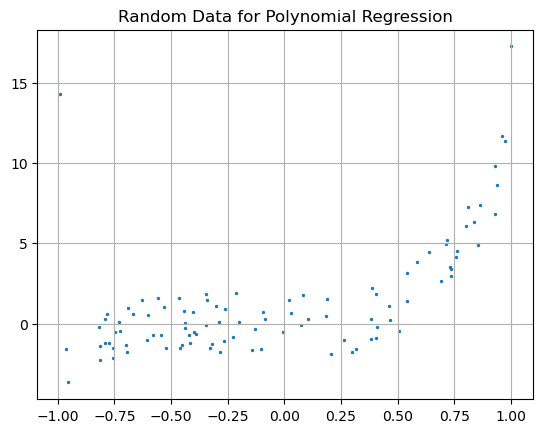

In [136]:
N = 100
x = np.random.uniform(-1, 1, N)
c = np.random.uniform(-5, 5, N)  # Coefficients for the polynomial
error = 4 * np.random.rand(N) - 1
y = sum(c[i] * x**i for i in range(len(c))) + error

plt.scatter(x, y, s=2)
plt.title('Random Data for Polynomial Regression')
plt.grid(True)
plt.show()

Let 

$$
z_i = |y_i - (c_n x_i^n + c_{n-1} x_i^{n-1} + \dots + c_1 x_i + c_0)|
$$

In the linear programming formulation, we aim to minimize:

$$
\begin{cases}
\min & \frac{1}{n}\sum_{i=1}^n z_i & \\ 
\text{subject to } & |y_i - (c_n x_i^n + c_{n-1} x_i^{n-1} + \dots + c_1 x_i + c_0)| \leqslant z_i, & i = 1, \dots , n \\
& c_0, c_1, \dots, c_n \in \mathbb{R}, \quad z_1, \dots, z_n \geqslant 0 &
\end{cases}
$$

$$
\implies \begin{cases}
\min & \frac{1}{n}\sum_{i=1}^n z_i & \\ 
\text{subject to } & y_i - (c_n x_i^n + c_{n-1} x_i^{n-1} + \dots + c_1 x_i + c_0) \leqslant z_i, & i = 1, \dots , n \\
& (c_n x_i^n + c_{n-1} x_i^{n-1} + \dots + c_1 x_i + c_0) - z_i \leqslant y_i, & i = 1, \dots , n \\
& c_0, c_1, \dots, c_n \in \mathbb{R}, \quad z_1, \dots, z_n \geqslant 0 &
\end{cases}
$$

$$
\implies \begin{cases}
\min & \frac{1}{n}\sum_{i=1}^n z_i & \\ 
\text{subject to } & -c_n x_i^n - c_{n-1} x_i^{n-1} - \dots - c_1 x_i - c_0 - z_i \leqslant -y_i, & i = 1, \dots , n \\
& (c_n x_i^n + c_{n-1} x_i^{n-1} + \dots + c_1 x_i + c_0) - z_i \leqslant y_i, & i = 1, \dots , n \\
& c_0, c_1, \dots, c_n \in \mathbb{R}, \quad z_1, \dots, z_n \geqslant 0 &
\end{cases}
$$

Rewriting the constraints in matrix form we get:

$$
\begin{bmatrix}
-1 & & & -1 & -x_1 & -x_1^2 & \dots & -x_1^n \\
 & \ddots & & \vdots & \vdots & \vdots & \dots & \vdots \\
 & & -1 & -1 & -x_n & -x_n^2 & \dots & -x_n^n \\
-1 & & & 1 & x_1 & x_1^2 & \dots & x_1^n \\
 & \ddots & & \vdots & \vdots & \vdots & \dots & \vdots \\
 & & -1 & 1 & x_n & x_n^2 & \dots & x_n^n \\
\end{bmatrix}
\begin{bmatrix} z_1 \\ \vdots \\ z_n \\ c_n \\ \vdots \\ c_1 \\ c_0 \end{bmatrix}
=
\begin{bmatrix} -I & -A \\ -I & A \end{bmatrix}
\begin{bmatrix} \mathbf{t} \\ \mathbf{c} \end{bmatrix}
\leqslant
\begin{bmatrix} -\mathbf{y} \\ \mathbf{y} \end{bmatrix}
$$

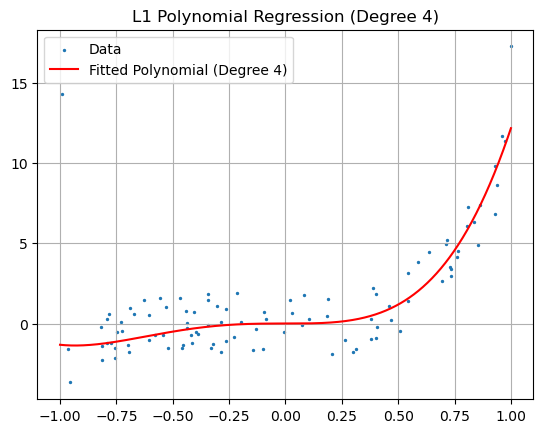

Coefficients: [0.         0.         0.         6.75053058 5.42592145]


In [137]:
n = 4  # Degree of the polynomial
A = np.vander(x, N=n+1, increasing=True)
B = np.block([[-np.eye(N), -A], [-np.eye(N), A]])
b = np.hstack([-y, y]).reshape((2*N, 1))
obj = np.hstack([np.ones(N), np.zeros(n+1)]).reshape((N+n+1,))
obj = obj / (N + n + 1)

result = linprog(c=obj, A_ub=B, b_ub=b)
coefficients_L1a = result.x[-(n+1):]

plt.scatter(x, y, s=2, label='Data')

x_range = np.linspace(-1, 1, 1000) 
y_line = sum(coefficients_L1a[i] * x_range**i for i in range(len(coefficients_L1a)))
plt.plot(x_range, y_line, color='red', label='Fitted Polynomial (Degree {})'.format(n))

plt.title('L1 Polynomial Regression (Degree {})'.format(n))
plt.legend()
plt.grid(True)
plt.show()

print("Coefficients:", coefficients_L1a)


## L2 Least Squares (Ridge Regression)

Given a set of data points:

$$
(x_1, y_1), \dots, (x_N, y_N), \quad x_i, y_i \in \mathbb{R}, \quad i = 1, \dots, N
$$

Our objective is to find a polynomial function of the form:

$$
f(x) = c_n x^n + c_{n-1} x^{n-1} + \dots + c_1 x + c_0
$$

where $ c_n, c_{n-1}, \dots, c_1, c_0 $ are coefficients to be determined, which best fits the given data. This involves minimizing the squared error:

\begin{align*}
\min_{c_n, c_{n-1}, \dots, c_1, c_0 \in \mathbb{R}} \frac{1}{n} \sum_{i=1}^{n} \|y_i - f(x_i)\|^2 \\
 \min_{c_n, c_{n-1}, \dots, c_1, c_0 \in \mathbb{R}} \frac{1}{n} \sum_{i=1}^{n} \|y_i - (c_n x_i^n + c_{n-1} x_i^{n-1} + \dots + c_1 x_i + c_0)\|^2 \\
\end{align*}

Since we are trying to find a solution $\hat{x}$ which minimzes the distance between $b$ and $Ax$ , we can write 

\begin{align*}
\hat{x} = \text{argmin}_x \| b - Ax_i \|^2_2
\end{align*}

If we let $f(x) = \| b - Ax\|_2^2 = \sum_i \left( b_i - \sum_j a_{ij} x_j \right)^2$, then we can find the minimum by taking the partial derivative with respect to $x_k$ to get the solution. So we get:

\begin{align*}
\frac{\partial f}{\partial x_k} (\hat{x}) = \sum_i 2 \left( b_i - \sum a_{ij} x_j \right) (-a_{ik}) = 0 \\
\implies \sum_i a_{ik} b_i = \sum_i \sum_j a_{ik} a_{ij} \hat{x}_j
\end{align*}

Rewriting this in matrix notation, we get:

$$
A^T = A^T A \hat{x} 
$$

And since A is invertible, we get our solution for the L-2 regression can be found by:

$$
\hat{x} = (A^T A)^{-1} A^T b
$$

Using the same data as from the example in L-1 regression, we can solve the problem.

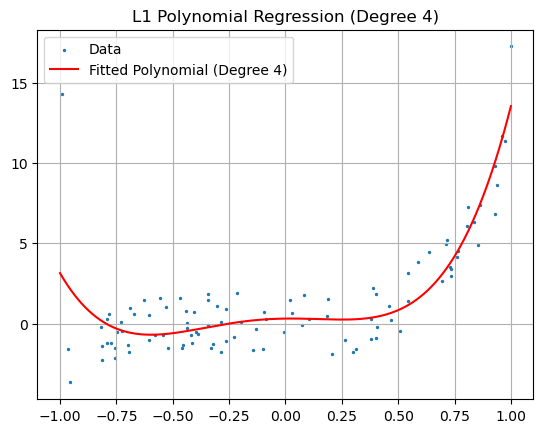

Coefficients: [ 0.30791754  0.18123934 -3.70791893  5.0237353  11.74719168]


In [138]:
n = 4 # Degree of the polynomial

A = np.vander(x, n + 1, increasing=True)

coefficients_L2a = np.linalg.inv(A.T @ A) @ A.T @ y

plt.scatter(x, y, s=2, label='Data')

x_range = np.linspace(-1, 1, 1000) 
y_line = sum(coefficients_L2a[i] * x_range**i for i in range(len(coefficients_L2a))) 
plt.plot(x_range, y_line, color='red', label='Fitted Polynomial (Degree {})'.format(n))

plt.title('L1 Polynomial Regression (Degree {})'.format(n))
plt.legend()
plt.grid(True)
plt.show()

print("Coefficients:", coefficients_L2a)

If we run the same two methods, on a dataset however that has less variation within the data, we should see different results. Let us generate some new data:

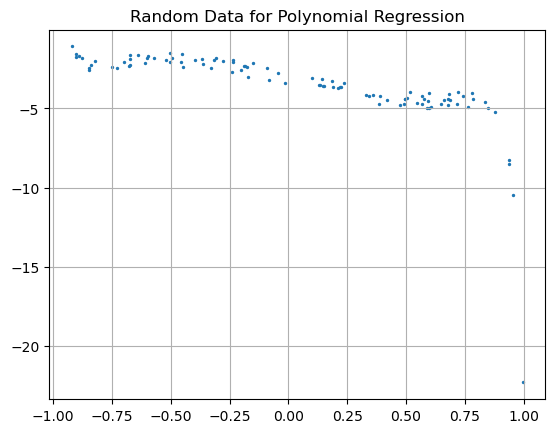

In [139]:
N = 100
x = np.random.uniform(-1, 1, N)
c = np.random.uniform(-5, 5, N)  # Coefficients for the polynomial
error =  np.random.rand(N) - 1
y = sum(c[i] * x**i for i in range(len(c))) + error_2

plt.scatter(x, y, s=2)
plt.title('Random Data for Polynomial Regression')
plt.grid(True)
plt.show()

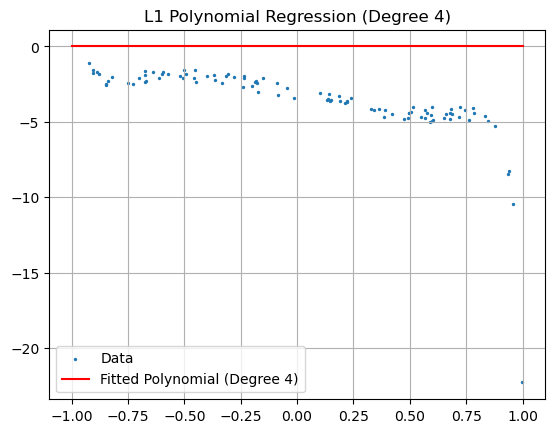

Coefficients: [0. 0. 0. 0. 0.]


In [140]:
n = 4  # Degree of the polynomial
A = np.vander(x, N=n+1, increasing=True)
B = np.block([[-np.eye(N), -A], [-np.eye(N), A]])
b = np.hstack([-y, y]).reshape((2*N, 1))
obj = np.hstack([np.ones(N), np.zeros(n+1)]).reshape((N+n+1,))
obj = obj / (N + n + 1)

result = linprog(c=obj, A_ub=B, b_ub=b)
coefficients_L1b = result.x[-(n+1):]

plt.scatter(x, y, s=2, label='Data')

x_range = np.linspace(-1, 1, 1000) 
y_line = sum(coefficients_L1b[i] * x_range**i for i in range(len(coefficients_L1b)))
plt.plot(x_range, y_line, color='red', label='Fitted Polynomial (Degree {})'.format(n))

plt.title('L1 Polynomial Regression (Degree {})'.format(n))
plt.legend()
plt.grid(True)
plt.show()

print("Coefficients:", coefficients_L1b)


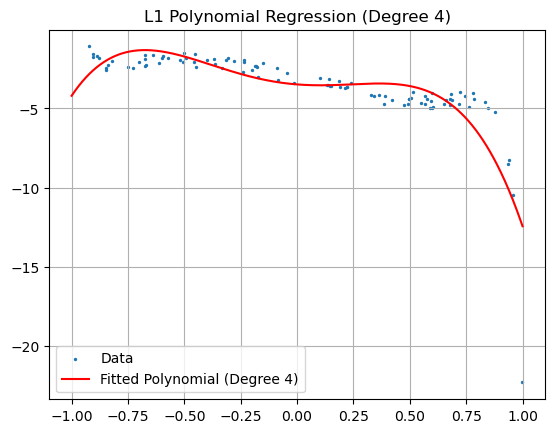

Coefficients: [ -3.49127739  -1.10979996   6.02177636  -3.00328243 -10.84994376]


In [141]:
n = 4 # Degree of the polynomial

A = np.vander(x, n + 1, increasing=True)

coefficients_L2a = np.linalg.inv(A.T @ A) @ A.T @ y

plt.scatter(x, y, s=2, label='Data')

x_range = np.linspace(-1, 1, 1000) 
y_line = sum(coefficients_L2a[i] * x_range**i for i in range(len(coefficients_L2a))) 
plt.plot(x_range, y_line, color='red', label='Fitted Polynomial (Degree {})'.format(n))

plt.title('L1 Polynomial Regression (Degree {})'.format(n))
plt.legend()
plt.grid(True)
plt.show()

print("Coefficients:", coefficients_L2a)

## Sensitivity Analysis

Visually, it's clear that as the data contains more outliers, the L2 (ridge) regression becomes more sensitive to this data. But how can we compare this sensitivity? The best way is to run both regressions on a dataset with known coefficients. From that, we can perform sensitivity analysis which involves several steps:

- We split the data into training and testing sets to assess the performance of the regression. By training the model on a subset of the data and testing it on unseen data, we can evaluate how well the model performs to detect overfitting.

- Next, we define a range of alpha values for sensitivity analysis to understand how the choice of regularization strength affects the model's performance. Regularization strength controls the trade-off between model complexity and the magnitude of coefficients. By varying alpha across a range of values, we can observe its impact on the model's ability to generalize to unseen data and its tendency to prevent overfitting. This is mathematically expressed as:

$$
\text{L1 Regularization:} \quad \min_{w} \left\{ \| y - Xw \|_2^2 + \alpha \|w\|_1 \right\}
$$
$$
\text{L2 Regularization:} \quad \min_{w} \left\{ \| y - Xw \|_2^2 + \alpha \|w\|_2^2 \right\}
$$

- Then, we run L1 (lasso) and L2 (ridge) regression models with different alpha values.

- The MSE is computed for both models on the testing set. A higher MSE suggests that the model's predictions are less accurate, which could be indicative of overfitting, underfitting, or other issues. Conversely, a lower MSE indicates that the model's predictions are closer to the actual values in the testing set, but it does not necessarily imply unbiased regression, as the model could still suffer from bias or high variance. This is mathematically defined as:

$$
\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2
$$

where $y_i$ are the actual values, and $\hat{y}_i$ are the predicted values.

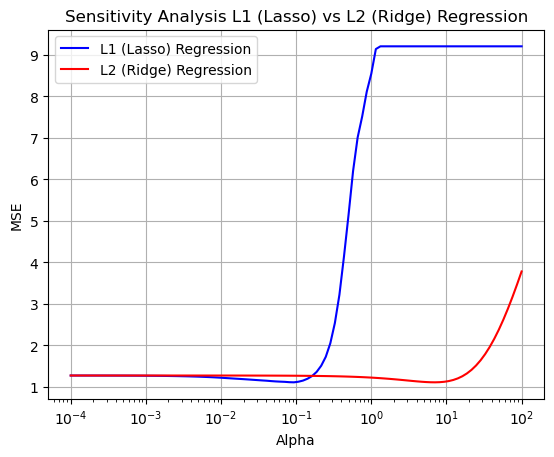

In [147]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(0)
n_samples, n_features = 100, 20
X = np.random.randn(n_samples, n_features)
coefficients = np.zeros(n_features)
coefficients[10:] = 1.0  # True coefficients
y = np.dot(X, coefficients) + np.random.normal(size=n_samples)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alphas = np.logspace(-4, 2, 100)

mse_lasso = []
mse_ridge = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    mse_lasso.append(mean_squared_error(y_test, y_pred_lasso))

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    mse_ridge.append(mean_squared_error(y_test, y_pred_ridge))

plt.plot(alphas, mse_lasso, label='L1 (Lasso) Regression', color='blue')
plt.plot(alphas, mse_ridge, label='L2 (Ridge) Regression', color='red')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Sensitivity Analysis L1 (Lasso) vs L2 (Ridge) Regression')
plt.legend()
plt.grid(True)
plt.show()

Since the MSE for L1 (Lasso) regression increases before the MSE for L2 (Ridge) regression in the sensitivity analysis, the L1 regularization method is more sensitive to changes in the regularization strength compared to the L2 regularization method. 

Lasso regression applies L1 regularization, which adds a penalty term proportional to the absolute values of the coefficients of the model. As the alpha increases in Lasso regression, more coefficients are penalized and potentially set to zero, leading to a simpler model with fewer features contributing to the prediction. However, if the regularization strength is too high, it may lead to underfitting, causing the MSE to increase.

Ridge regression applies L2 regularization, which adds a penalty term proportional to the squared values of the coefficients. This penalty encourages small but non-zero coefficients for all features. As the regularization strength (alpha) increases in Ridge regression, all coefficients are shrunk towards zero, but none are exactly zero. Ridge regression is generally less sensitive to changes in alpha compared to Lasso regression.

Most notably we see that L1 regression hits a minimum for a small value of alpha than L2 regression. This means that an optimal model for L1 regression requires less of a penalty than L2 regression. This confirms the fact that L2 regression is more likley to overfit its data as compared to L1 regression.

## References

1. Walls, P. (2022). Math 307 Notes. [Fitting Models to Data](https://ubcmath.github.io/MATH307/notebooks/06_least_squares_regression.html)

2. Prof. Yuanlong, R. (2024, Mar) - Email correspondence

3. [Ridge Regression](https://en.wikipedia.org/wiki/Ridge_regression)

4. [Lasso Regression](https://en.wikipedia.org/wiki/Lasso_(statistics))
